In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [ ]:

!wget -q http://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz


In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
!pip install stop-words
!pip install --quiet findspark
!pip install emoji
!pip install language-tool-python
!pip install pysentimiento
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark
import pandas as pd
import numpy as np
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:

findspark.init()
sc=SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
jdf= spark.read.csv("/content/drive/MyDrive/DATASETS/gaza_israel - gaza_israel.csv", header=True, inferSchema=True)

# New Section

In [ ]:
jdf.show()

+---+----+--------------------+---------------+--------------------+--------------------+--------+--------+---------+-----------+-------------------+--------------------+------------+--------------------+--------+
|_c0| _c1|                Name|       Username|        User Profile|            Tweet ID|Retweets|Comments|Favorites|Is Retweet?|               Date|          Tweet Text|Tweet Source|          Status URL|   SCORE|
+---+----+--------------------+---------------+--------------------+--------------------+--------+--------+---------+-----------+-------------------+--------------------+------------+--------------------+--------+
|  1|NULL|      CNN en Español|          CNNEE|https://www.twitt...|ID: 1719064401330...|      84|     117|      389|       NULL|2023-10-30 18:51:06|"Netanyahu: ""Isr...|        NULL|https://www.twitt...| Neutral|
|  2|NULL|^Malo del Alma^ E...|         jazzun|https://www.twitt...|ID: 1719064401330...|       0|       0|        2|       NULL|2023-10-30 18:5

In [ ]:
df = jdf.toPandas()

In [ ]:
import emoji
import collections

def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)



In [ ]:
# Supongamos que tienes un DataFrame llamado df con una columna 'text' que contiene los tweets
df['emojis'] = df['Tweet Text'].apply(extract_emojis)

In [ ]:
df.head()

,_c0,_c1,Name,Username,User Profile,Tweet ID,Retweets,Comments,Favorites,Is Retweet?,Date,Tweet Text,Tweet Source,Status URL,emojis
0,1,None,CNN en Español,CNNEE,https://www.twitter.com/CNNEE,ID: 1719064401330966689,84,117,389,None,2023-10-30 18:51:06,"""Netanyahu: """"Israel no aceptará un cese de ho...",None,https://www.twitter.com/CNNEE/status/171906440...,
1,2,None,^Malo del Alma^ EN CONTRA🇨🇱🌈🪴 😎,jazzun,https://www.twitter.com/jazzun,ID: 1719064401330966689,0,0,2,None,2023-10-30 18:52:11,@CNNEE Fácil decirlo tras las polleras de EEUU,None,https://www.twitter.com/jazzun/status/17190644...,
2,3,None,Carolina ♡,Carolin72908345,https://www.twitter.com/Carolin72908345,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:53:23,@CNNEE 🫣,None,https://www.twitter.com/Carolin72908345/status...,🫣
3,4,None,Israel Ramos,IsraPanter,https://www.twitter.com/IsraPanter,ID: 1719064401330966689,2,2,7,None,2023-10-30 18:53:31,@CNNEE https://t.co/ph5DRKsGuY,None,https://www.twitter.com/IsraPanter/status/1719...,
4,5,None,Alexis Segovia,AlexisS78626235,https://www.twitter.com/AlexisS78626235,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:54:55,@CNNEE Así es,None,https://www.twitter.com/AlexisS78626235/status...,


In [ ]:
# Ahora, puedes contar la frecuencia de cada emoji
all_emojis = ''.join(df['emojis'].tolist())
emoji_freq = collections.Counter(all_emojis)

# Mostrar los emojis más comunes y sus frecuencias
print(emoji_freq.most_common(10))

[('💪', 5), ('😞', 5), ('💀', 3), ('🤮', 3), ('\U0001fae3', 1), ('🌍', 1), ('🤢', 1), ('💣', 1), ('👍', 1), ('⛈', 1)]


In [ ]:
emoji_sentiments = {
    '💪': 'POS',
    '😞': 'NEG',
    '🤮': 'NEG',
    '🤢': 'NEG',
    '👍': 'POS'
}

In [ ]:
def label_emoji_sentiment(emoji_list):
    # Inicializa los contadores para cada tipo de sentimiento
    positive = negative = 0

    # Cuenta la ocurrencia de cada sentimiento
    for emoji in emoji_list:
        sentiment = emoji_sentiments.get(emoji, 'NEU')
        if sentiment == 'POS':
            positive += 1
        elif sentiment == 'NEG':
            negative += 1

    # Determina la etiqueta final basada en los contadores
    if positive > negative:
        return 'POSITIVO'
    elif negative > positive:
        return 'NEGATIVO'
    else:
        return 'NEUTRAL'  # Neutral si hay un empate o todos los emojis son neutrales



In [ ]:
df['emoji_sentiment_score'] = df['emojis'].apply(label_emoji_sentiment)


In [ ]:
df.head(40)

,_c0,_c1,Name,Username,User Profile,Tweet ID,Retweets,Comments,Favorites,Is Retweet?,Date,Tweet Text,Tweet Source,Status URL,emojis,emoji_sentiment_score
0,1,None,CNN en Español,CNNEE,https://www.twitter.com/CNNEE,ID: 1719064401330966689,84,117,389,None,2023-10-30 18:51:06,"""Netanyahu: """"Israel no aceptará un cese de ho...",None,https://www.twitter.com/CNNEE/status/171906440...,,NEUTRAL
1,2,None,^Malo del Alma^ EN CONTRA🇨🇱🌈🪴 😎,jazzun,https://www.twitter.com/jazzun,ID: 1719064401330966689,0,0,2,None,2023-10-30 18:52:11,@CNNEE Fácil decirlo tras las polleras de EEUU,None,https://www.twitter.com/jazzun/status/17190644...,,NEUTRAL
2,3,None,Carolina ♡,Carolin72908345,https://www.twitter.com/Carolin72908345,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:53:23,@CNNEE 🫣,None,https://www.twitter.com/Carolin72908345/status...,🫣,NEUTRAL
3,4,None,Israel Ramos,IsraPanter,https://www.twitter.com/IsraPanter,ID: 1719064401330966689,2,2,7,None,2023-10-30 18:53:31,@CNNEE https://t.co/ph5DRKsGuY,None,https://www.twitter.com/IsraPanter/status/1719...,,NEUTRAL
4,5,None,Alexis Segovia,AlexisS78626235,https://www.twitter.com/AlexisS78626235,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:54:55,@CNNEE Así es,None,https://www.twitter.com/AlexisS78626235/status...,,NEUTRAL
5,6,None,Víctor Iglesias González 🇪🇸🇮🇱,VictorIG80,https://www.twitter.com/VictorIG80,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:05,@CNNEE Las Legiones de Demonios junto a los Si...,None,https://www.twitter.com/VictorIG80/status/1719...,,NEUTRAL
6,7,None,monica VIP* Anti Ka.,TullioMonica,https://www.twitter.com/TullioMonica,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:55:14,@CNNEE Desgraciado,None,https://www.twitter.com/TullioMonica/status/17...,,NEUTRAL
7,8,None,Ula Barison. Miliciana.,UlaBarison5,https://www.twitter.com/UlaBarison5,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:19,@CNNEE Genocida delirante asqueroso asesino de...,None,https://www.twitter.com/UlaBarison5/status/171...,,NEUTRAL
8,9,None,La Carnala Mayor,La_Carnala,https://www.twitter.com/La_Carnala,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:23,@CNNEE #IsraelGenocida,None,https://www.twitter.com/La_Carnala/status/1719...,,NEUTRAL
9,10,None,Manuel Martìnez,mmartinez975,https://www.twitter.com/mmartinez975,ID: 1719064401330966689,0,3,6,None,2023-10-30 18:55:58,@CNNEE Hamas va a ser barrida,None,https://www.twitter.com/mmartinez975/status/17...,,NEUTRAL


In [ ]:
import re
def cleaned_text(comment):

    caracteres_no_verbales = ['❤', '💔', '😀', '🙂', '👍', '👎', '😂', '✌', '💥', '🌟']

    # Crear una expresión regular para buscar y eliminar estos caracteres
    patron = '|'.join(map(re.escape, caracteres_no_verbales))
    texto_sin_repeticiones = re.sub(r'@[\w]+', '', comment)

    texto_sin_repeticiones = re.sub(patron, '', texto_sin_repeticiones)
    # Expresión regular para buscar y eliminar menciones de usuarios (@nombreusuario)


    # Utilizar una expresión regular para eliminar caracteres no deseados y URLs, pero conservar las letras con tilde, la letra "ñ" y otros caracteres especiales
    texto_sin_repeticiones = re.sub(r'https?://\S+|[^a-zA-Z0-9\s#@áéíóúüñÁÉÍÓÚÜÑ+!]', '', texto_sin_repeticiones)
    texto_sin_repeticiones = re.sub(r'#', '', texto_sin_repeticiones)
    # Convertir el texto a minúsculas antes de la traducción
    texto_sin_repeticiones = texto_sin_repeticiones.lower()

    return texto_sin_repeticiones



In [ ]:
df['clean_text'] = df['Tweet Text'].apply(cleaned_text)

In [ ]:
df.head(60)

,_c0,_c1,Name,Username,User Profile,Tweet ID,Retweets,Comments,Favorites,Is Retweet?,Date,Tweet Text,Tweet Source,Status URL,emojis,emoji_sentiment_score,clean_text
0,1,None,CNN en Español,CNNEE,https://www.twitter.com/CNNEE,ID: 1719064401330966689,84,117,389,None,2023-10-30 18:51:06,"""Netanyahu: """"Israel no aceptará un cese de ho...",None,https://www.twitter.com/CNNEE/status/171906440...,,NEUTRAL,netanyahu israel no aceptará un cese de hostil...
1,2,None,^Malo del Alma^ EN CONTRA🇨🇱🌈🪴 😎,jazzun,https://www.twitter.com/jazzun,ID: 1719064401330966689,0,0,2,None,2023-10-30 18:52:11,@CNNEE Fácil decirlo tras las polleras de EEUU,None,https://www.twitter.com/jazzun/status/17190644...,,NEUTRAL,fácil decirlo tras las polleras de eeuu
2,3,None,Carolina ♡,Carolin72908345,https://www.twitter.com/Carolin72908345,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:53:23,@CNNEE 🫣,None,https://www.twitter.com/Carolin72908345/status...,🫣,NEUTRAL,
3,4,None,Israel Ramos,IsraPanter,https://www.twitter.com/IsraPanter,ID: 1719064401330966689,2,2,7,None,2023-10-30 18:53:31,@CNNEE https://t.co/ph5DRKsGuY,None,https://www.twitter.com/IsraPanter/status/1719...,,NEUTRAL,
4,5,None,Alexis Segovia,AlexisS78626235,https://www.twitter.com/AlexisS78626235,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:54:55,@CNNEE Así es,None,https://www.twitter.com/AlexisS78626235/status...,,NEUTRAL,así es
5,6,None,Víctor Iglesias González 🇪🇸🇮🇱,VictorIG80,https://www.twitter.com/VictorIG80,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:05,@CNNEE Las Legiones de Demonios junto a los Si...,None,https://www.twitter.com/VictorIG80/status/1719...,,NEUTRAL,las legiones de demonios junto a los siervos ...
6,7,None,monica VIP* Anti Ka.,TullioMonica,https://www.twitter.com/TullioMonica,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:55:14,@CNNEE Desgraciado,None,https://www.twitter.com/TullioMonica/status/17...,,NEUTRAL,desgraciado
7,8,None,Ula Barison. Miliciana.,UlaBarison5,https://www.twitter.com/UlaBarison5,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:19,@CNNEE Genocida delirante asqueroso asesino de...,None,https://www.twitter.com/UlaBarison5/status/171...,,NEUTRAL,genocida delirante asqueroso asesino de niños...
8,9,None,La Carnala Mayor,La_Carnala,https://www.twitter.com/La_Carnala,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:23,@CNNEE #IsraelGenocida,None,https://www.twitter.com/La_Carnala/status/1719...,,NEUTRAL,israelgenocida
9,10,None,Manuel Martìnez,mmartinez975,https://www.twitter.com/mmartinez975,ID: 1719064401330966689,0,3,6,None,2023-10-30 18:55:58,@CNNEE Hamas va a ser barrida,None,https://www.twitter.com/mmartinez975/status/17...,,NEUTRAL,hamas va a ser barrida


Se corregira errores del español

In [ ]:

from language_tool_python import LanguageTool

# Crear una instancia de LanguageTool para español
tool = LanguageTool('es')

# Función para aplicar correcciones al texto en una columna
def corregir_texto(text):
    return tool.correct(text)


INFO:language_tool_python.download_lt:Unzipping /tmp/tmpcq4g1xqp.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-5.7.zip to /root/.cache/language_tool_python.


In [ ]:
# Aplicar la corrección a la columna 'texto'
df['correctec_text'] = df['clean_text'].apply(corregir_texto)


In [ ]:
df.head(50)

,_c0,_c1,Name,Username,User Profile,Tweet ID,Retweets,Comments,Favorites,Is Retweet?,Date,Tweet Text,Tweet Source,Status URL,SCORE,clean_text,correctec_text
0,1,None,CNN en Español,CNNEE,https://www.twitter.com/CNNEE,ID: 1719064401330966689,84,117,389,None,2023-10-30 18:51:06,"""Netanyahu: """"Israel no aceptará un cese de ho...",None,https://www.twitter.com/CNNEE/status/171906440...,Neutral,netanyahu israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hostil...
1,2,None,^Malo del Alma^ EN CONTRA🇨🇱🌈🪴 😎,jazzun,https://www.twitter.com/jazzun,ID: 1719064401330966689,0,0,2,None,2023-10-30 18:52:11,@CNNEE Fácil decirlo tras las polleras de EEUU,None,https://www.twitter.com/jazzun/status/17190644...,Positivo,fácil decirlo tras las polleras de eeuu,Fácil decirlo tras las polleras de EEUU
2,3,None,Carolina ♡,Carolin72908345,https://www.twitter.com/Carolin72908345,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:53:23,@CNNEE 🫣,None,https://www.twitter.com/Carolin72908345/status...,Neutral,,
3,4,None,Israel Ramos,IsraPanter,https://www.twitter.com/IsraPanter,ID: 1719064401330966689,2,2,7,None,2023-10-30 18:53:31,@CNNEE https://t.co/ph5DRKsGuY,None,https://www.twitter.com/IsraPanter/status/1719...,Negativo,,
4,5,None,Alexis Segovia,AlexisS78626235,https://www.twitter.com/AlexisS78626235,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:54:55,@CNNEE Así es,None,https://www.twitter.com/AlexisS78626235/status...,Neutral,así es,Así es
5,6,None,Víctor Iglesias González 🇪🇸🇮🇱,VictorIG80,https://www.twitter.com/VictorIG80,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:05,@CNNEE Las Legiones de Demonios junto a los Si...,None,https://www.twitter.com/VictorIG80/status/1719...,Neutral,las legiones de demonios junto a los siervos ...,Las legiones de demonios junto a los siervos ...
6,7,None,monica VIP* Anti Ka.,TullioMonica,https://www.twitter.com/TullioMonica,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:55:14,@CNNEE Desgraciado,None,https://www.twitter.com/TullioMonica/status/17...,Negativo,desgraciado,Desgraciado
7,8,None,Ula Barison. Miliciana.,UlaBarison5,https://www.twitter.com/UlaBarison5,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:19,@CNNEE Genocida delirante asqueroso asesino de...,None,https://www.twitter.com/UlaBarison5/status/171...,Negativo,genocida delirante asqueroso asesino de niños...,Genocida delirante asqueroso asesino de niños...
8,9,None,La Carnala Mayor,La_Carnala,https://www.twitter.com/La_Carnala,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:23,@CNNEE #IsraelGenocida,None,https://www.twitter.com/La_Carnala/status/1719...,Negativo,israelgenocida,israelgenocida
9,10,None,Manuel Martìnez,mmartinez975,https://www.twitter.com/mmartinez975,ID: 1719064401330966689,0,3,6,None,2023-10-30 18:55:58,@CNNEE Hamas va a ser barrida,None,https://www.twitter.com/mmartinez975/status/17...,Positivo,hamas va a ser barrida,Hamás va a ser barrida


GENERAR WORDCLOUD

In [ ]:
import pandas as pd

def convert_texts_to_lowercase(df, column_name):
    if column_name in df.columns:
        return df[column_name].str.lower()
    else:
        print(f"La columna '{column_name}' no existe en el DataFrame.")
        return None



In [ ]:
convert_texts_to_lowercase(df,'Tweet Text')

0      "netanyahu: ""israel no aceptará un cese de ho...
1         @cnnee fácil decirlo tras las polleras de eeuu
2                                               @cnnee 🫣
3                         @cnnee https://t.co/ph5drksguy
4                                          @cnnee así es
                             ...                        
96                                @cnnee #nooilforisrael
97     @cnnee aver que dices cerdo criminal  cuando d...
98     @cnnee claro quiere dar de comer alos trafican...
99     @cnnee en vez de buscarlos alos terroristas no...
100    @cnnee pero no es posible desaoarecer una naci...
Name: Tweet Text, Length: 101, dtype: object

In [ ]:
Tweet_Texts= df['Tweet Text'].values

In [ ]:
Tweet_String = str(Tweet_Texts)

In [ ]:
Tweet_Text_Cleaned= Tweet_String.lower()

In [ ]:
import re
def clean_text(text_to_clean):
  c_text= re.sub(r'@\w+', ' ', text_to_clean)
  c_text= re.sub(r'http\S+', ' ', c_text)
  c_text= re.sub(r'https?://\S+|[^a-zA-Z0-9\s#@áéíóúüñÁÉÍÓÚÜÑ+!]', ' ', c_text)
  c_text= re.sub(r' +', ' ', c_text)
  return c_text.strip()



In [ ]:
new_text_cleaned= clean_text(Tweet_Text_Cleaned)

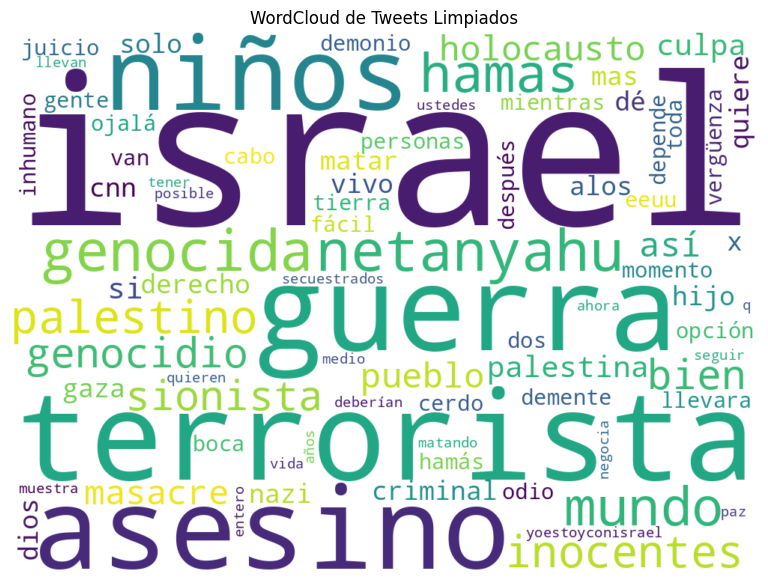

In [ ]:
from wordcloud import WordCloud

from stop_words import get_stop_words


wordcloud = WordCloud(width=1000, height=720,
                      max_words=80,max_font_size=500,
                          font_step=2,
                      background_color='white', stopwords=get_stop_words('es')).generate(new_text_cleaned)

# Visualizar el WordCloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Oculta los ejes
plt.title('WordCloud de Tweets Limpiados')
plt.show()

PREPROCESAR LOS TWEETS CON PYSENTIMIENTO

In [ ]:

from pysentimiento.preprocessing import preprocess_tweet
def custom_preprocess(text):
    text= re.sub(r'@\w+', ' ', text)
    text= re.sub(r'https?://\S+|[^a-zA-Z0-9\s#@áéíóúüñÁÉÍÓÚÜÑ+!]', ' ', text)
    # Reemplaza menciones y URLs
    text = preprocess_tweet(text)

    # Acorta caracteres repetidos
    text = preprocess_tweet(text, shorten=2)

    # Normaliza risas
    text = preprocess_tweet(text)

    # Maneja hashtags
    text = preprocess_tweet(text)

    # Maneja emojis
    text = preprocess_tweet(text, lang="es")


    return text




In [ ]:
df['processed_text'] = df['Tweet Text'].apply(custom_preprocess)

In [ ]:
df.head(40)

,_c0,_c1,Name,Username,User Profile,Tweet ID,Retweets,Comments,Favorites,Is Retweet?,Date,Tweet Text,Tweet Source,Status URL,SCORE,clean_text,correctec_text,processed_text
0,1,None,CNN en Español,CNNEE,https://www.twitter.com/CNNEE,ID: 1719064401330966689,84,117,389,None,2023-10-30 18:51:06,"""Netanyahu: """"Israel no aceptará un cese de ho...",None,https://www.twitter.com/CNNEE/status/171906440...,Neutral,netanyahu israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hosti...
1,2,None,^Malo del Alma^ EN CONTRA🇨🇱🌈🪴 😎,jazzun,https://www.twitter.com/jazzun,ID: 1719064401330966689,0,0,2,None,2023-10-30 18:52:11,@CNNEE Fácil decirlo tras las polleras de EEUU,None,https://www.twitter.com/jazzun/status/17190644...,Positivo,fácil decirlo tras las polleras de eeuu,Fácil decirlo tras las polleras de EEUU,Fácil decirlo tras las polleras de EEUU
2,3,None,Carolina ♡,Carolin72908345,https://www.twitter.com/Carolin72908345,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:53:23,@CNNEE 🫣,None,https://www.twitter.com/Carolin72908345/status...,Neutral,,,
3,4,None,Israel Ramos,IsraPanter,https://www.twitter.com/IsraPanter,ID: 1719064401330966689,2,2,7,None,2023-10-30 18:53:31,@CNNEE https://t.co/ph5DRKsGuY,None,https://www.twitter.com/IsraPanter/status/1719...,Negativo,,,
4,5,None,Alexis Segovia,AlexisS78626235,https://www.twitter.com/AlexisS78626235,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:54:55,@CNNEE Así es,None,https://www.twitter.com/AlexisS78626235/status...,Neutral,así es,Así es,Así es
5,6,None,Víctor Iglesias González 🇪🇸🇮🇱,VictorIG80,https://www.twitter.com/VictorIG80,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:05,@CNNEE Las Legiones de Demonios junto a los Si...,None,https://www.twitter.com/VictorIG80/status/1719...,Neutral,las legiones de demonios junto a los siervos ...,Las legiones de demonios junto a los siervos ...,Las Legiones de Demonios junto a los Siervos d...
6,7,None,monica VIP* Anti Ka.,TullioMonica,https://www.twitter.com/TullioMonica,ID: 1719064401330966689,0,0,0,None,2023-10-30 18:55:14,@CNNEE Desgraciado,None,https://www.twitter.com/TullioMonica/status/17...,Negativo,desgraciado,Desgraciado,Desgraciado
7,8,None,Ula Barison. Miliciana.,UlaBarison5,https://www.twitter.com/UlaBarison5,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:19,@CNNEE Genocida delirante asqueroso asesino de...,None,https://www.twitter.com/UlaBarison5/status/171...,Negativo,genocida delirante asqueroso asesino de niños...,Genocida delirante asqueroso asesino de niños...,Genocida delirante asqueroso asesino de niños ...
8,9,None,La Carnala Mayor,La_Carnala,https://www.twitter.com/La_Carnala,ID: 1719064401330966689,0,0,1,None,2023-10-30 18:55:23,@CNNEE #IsraelGenocida,None,https://www.twitter.com/La_Carnala/status/1719...,Negativo,israelgenocida,israelgenocida,hashtag israel genocida
9,10,None,Manuel Martìnez,mmartinez975,https://www.twitter.com/mmartinez975,ID: 1719064401330966689,0,3,6,None,2023-10-30 18:55:58,@CNNEE Hamas va a ser barrida,None,https://www.twitter.com/mmartinez975/status/17...,Positivo,hamas va a ser barrida,Hamás va a ser barrida,Hamas va a ser barrida


In [ ]:
from pysentimiento import create_analyzer

# Crear una instancia del analizador de sentimiento
analyzer = create_analyzer(task="sentiment", lang="es")

hate_speech_analyzer = create_analyzer(task="hate_speech", lang="es")

# Función para aplicar el análisis de sentimiento a un texto
def analizar_sentimiento(text):
    return analyzer.predict(text)

# Función para aplicar el análisis de sentimiento a un texto
def analizar_odio(text):
    return hate_speech_analyzer.predict(text)




In [ ]:

# Aplicar el análisis de sentimiento a la columna 'texto'
df['sentimiento'] = df['correctec_text'].apply(analizar_sentimiento)
df['sentimiento_pysentimiento'] = df['processed_text'].apply(analizar_sentimiento)
df['sentimiento_odio'] = df['correctec_text'].apply(analizar_odio)

In [ ]:
df.head()

,_c0,_c1,Name,Username,User Profile,Tweet ID,Retweets,Comments,Favorites,Is Retweet?,...,Tweet Text,Tweet Source,Status URL,SCORE,clean_text,correctec_text,processed_text,sentimiento,sentimiento_pysentimiento,sentimiento_odio
0,1,None,CNN en Español,CNNEE,https://www.twitter.com/CNNEE,ID: 1719064401330966689,84,117,389,None,...,"""Netanyahu: """"Israel no aceptará un cese de ho...",None,https://www.twitter.com/CNNEE/status/171906440...,Neutral,netanyahu israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hosti...,"AnalyzerOutput(output=NEG, probas={NEG: 0.760,...","AnalyzerOutput(output=NEG, probas={NEG: 0.695,...","AnalyzerOutput(output=[], probas={hateful: 0.0..."
1,2,None,^Malo del Alma^ EN CONTRA🇨🇱🌈🪴 😎,jazzun,https://www.twitter.com/jazzun,ID: 1719064401330966689,0,0,2,None,...,@CNNEE Fácil decirlo tras las polleras de EEUU,None,https://www.twitter.com/jazzun/status/17190644...,Positivo,fácil decirlo tras las polleras de eeuu,Fácil decirlo tras las polleras de EEUU,Fácil decirlo tras las polleras de EEUU,"AnalyzerOutput(output=NEG, probas={NEG: 0.600,...","AnalyzerOutput(output=NEG, probas={NEG: 0.600,...","AnalyzerOutput(output=[], probas={hateful: 0.4..."
2,3,None,Carolina ♡,Carolin72908345,https://www.twitter.com/Carolin72908345,ID: 1719064401330966689,0,0,0,None,...,@CNNEE 🫣,None,https://www.twitter.com/Carolin72908345/status...,Neutral,,,,"AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=['hateful', 'targeted'],..."
3,4,None,Israel Ramos,IsraPanter,https://www.twitter.com/IsraPanter,ID: 1719064401330966689,2,2,7,None,...,@CNNEE https://t.co/ph5DRKsGuY,None,https://www.twitter.com/IsraPanter/status/1719...,Negativo,,,,"AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=['hateful', 'targeted'],..."
4,5,None,Alexis Segovia,AlexisS78626235,https://www.twitter.com/AlexisS78626235,ID: 1719064401330966689,0,0,0,None,...,@CNNEE Así es,None,https://www.twitter.com/AlexisS78626235/status...,Neutral,así es,Así es,Así es,"AnalyzerOutput(output=NEU, probas={NEU: 0.624,...","AnalyzerOutput(output=NEU, probas={NEU: 0.624,...","AnalyzerOutput(output=[], probas={hateful: 0.0..."


In [ ]:
# Extraer solo el valor 'output' y almacenarlo en otra columna
df['sentimiento_score'] = df['sentimiento'].apply(lambda x: x.output)
df['sentimiento_score_pysentimiento'] = df['sentimiento_pysentimiento'].apply(lambda x: x.output)
df['sentimiento_score_odio'] = df['sentimiento_odio'].apply(lambda x: x.output)

In [ ]:
df.head()

,_c0,_c1,Name,Username,User Profile,Tweet ID,Retweets,Comments,Favorites,Is Retweet?,...,SCORE,clean_text,correctec_text,processed_text,sentimiento,sentimiento_pysentimiento,sentimiento_odio,sentimiento_score,sentimiento_score_odio,sentimiento_score_pysentimiento
0,1,None,CNN en Español,CNNEE,https://www.twitter.com/CNNEE,ID: 1719064401330966689,84,117,389,None,...,Neutral,netanyahu israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hosti...,"AnalyzerOutput(output=NEG, probas={NEG: 0.760,...","AnalyzerOutput(output=NEG, probas={NEG: 0.695,...","AnalyzerOutput(output=[], probas={hateful: 0.0...",NEG,[],NEG
1,2,None,^Malo del Alma^ EN CONTRA🇨🇱🌈🪴 😎,jazzun,https://www.twitter.com/jazzun,ID: 1719064401330966689,0,0,2,None,...,Positivo,fácil decirlo tras las polleras de eeuu,Fácil decirlo tras las polleras de EEUU,Fácil decirlo tras las polleras de EEUU,"AnalyzerOutput(output=NEG, probas={NEG: 0.600,...","AnalyzerOutput(output=NEG, probas={NEG: 0.600,...","AnalyzerOutput(output=[], probas={hateful: 0.4...",NEG,[],NEG
2,3,None,Carolina ♡,Carolin72908345,https://www.twitter.com/Carolin72908345,ID: 1719064401330966689,0,0,0,None,...,Neutral,,,,"AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=['hateful', 'targeted'],...",POS,"[hateful, targeted]",POS
3,4,None,Israel Ramos,IsraPanter,https://www.twitter.com/IsraPanter,ID: 1719064401330966689,2,2,7,None,...,Negativo,,,,"AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=['hateful', 'targeted'],...",POS,"[hateful, targeted]",POS
4,5,None,Alexis Segovia,AlexisS78626235,https://www.twitter.com/AlexisS78626235,ID: 1719064401330966689,0,0,0,None,...,Neutral,así es,Así es,Así es,"AnalyzerOutput(output=NEU, probas={NEU: 0.624,...","AnalyzerOutput(output=NEU, probas={NEU: 0.624,...","AnalyzerOutput(output=[], probas={hateful: 0.0...",NEU,[],NEU


CLASIFICACION MANUAL

Counter({'Negativo': 63, 'Positivo': 22, 'Neutral': 15, 'https://www.twitter.com/pila1144/status/1719064401330966689': 1})


<Axes: xlabel='SCORE', ylabel='count'>

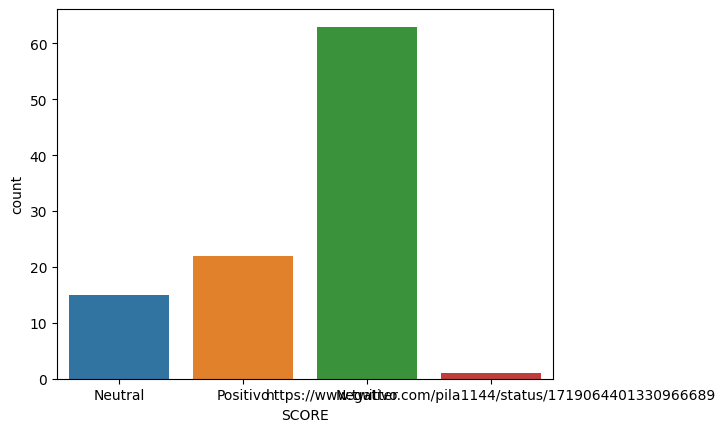

In [ ]:
x = df['correctec_text']
y = df.SCORE

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

CLASIFICACION AUTOMATIZADO PYSENTIMIENTO  -- 439 stars

Counter({'NEG': 59, 'POS': 21, 'NEU': 21})


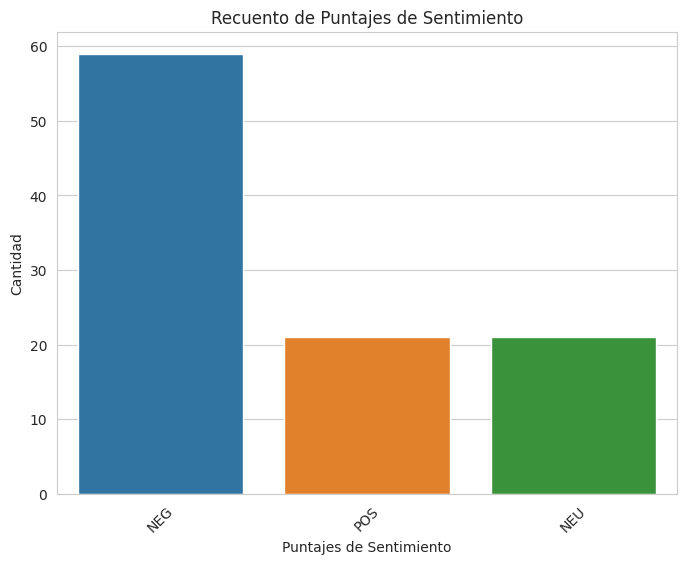

In [ ]:
from collections import Counter

x = df['correctec_text']
y = df['sentimiento_score']


print(Counter(y))

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")  # Establece un fondo de cuadrícula blanco
sns.countplot(data=df, x='sentimiento_score', palette='viridis')  # Usa la paleta de colores 'viridis'
sns.countplot(x=y)
plt.xlabel('Puntajes de Sentimiento')
plt.ylabel('Cantidad')
plt.title('Recuento de Puntajes de Sentimiento')
plt.xticks(rotation=45)  # Rota las etiquetas en el eje x para mayor legibilidad
plt.show()

Counter({'NEG': 62, 'POS': 23, 'NEU': 16})


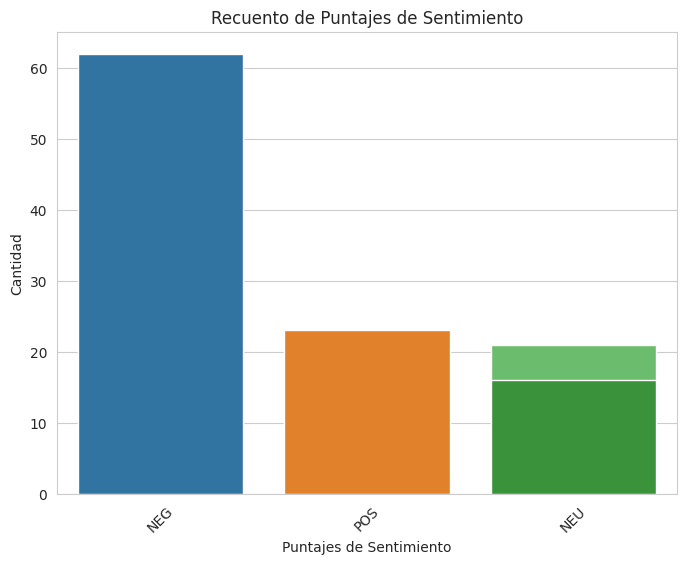

In [ ]:
from collections import Counter

x = df['correctec_text']
y = df['sentimiento_score_pysentimiento']


print(Counter(y))

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")  # Establece un fondo de cuadrícula blanco
sns.countplot(data=df, x='sentimiento_score', palette='viridis')  # Usa la paleta de colores 'viridis'
sns.countplot(x=y)
plt.xlabel('Puntajes de Sentimiento')
plt.ylabel('Cantidad')
plt.title('Recuento de Puntajes de Sentimiento')
plt.xticks(rotation=45)  # Rota las etiquetas en el eje x para mayor legibilidad
plt.show()

In [ ]:
print(df['correctec_text'].isnull().sum())
print(df['sentimiento_score'].isnull().sum())
df.head()

0
0


,_c0,_c1,Name,Username,User Profile,Tweet ID,Retweets,Comments,Favorites,Is Retweet?,...,SCORE,clean_text,correctec_text,processed_text,sentimiento,sentimiento_pysentimiento,sentimiento_odio,sentimiento_score,sentimiento_score_odio,sentimiento_score_pysentimiento
0,1,None,CNN en Español,CNNEE,https://www.twitter.com/CNNEE,ID: 1719064401330966689,84,117,389,None,...,Neutral,netanyahu israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hostil...,Netanyahu Israel no aceptará un cese de hosti...,"AnalyzerOutput(output=NEG, probas={NEG: 0.760,...","AnalyzerOutput(output=NEG, probas={NEG: 0.695,...","AnalyzerOutput(output=[], probas={hateful: 0.0...",NEG,[],NEG
1,2,None,^Malo del Alma^ EN CONTRA🇨🇱🌈🪴 😎,jazzun,https://www.twitter.com/jazzun,ID: 1719064401330966689,0,0,2,None,...,Positivo,fácil decirlo tras las polleras de eeuu,Fácil decirlo tras las polleras de EEUU,Fácil decirlo tras las polleras de EEUU,"AnalyzerOutput(output=NEG, probas={NEG: 0.600,...","AnalyzerOutput(output=NEG, probas={NEG: 0.600,...","AnalyzerOutput(output=[], probas={hateful: 0.4...",NEG,[],NEG
2,3,None,Carolina ♡,Carolin72908345,https://www.twitter.com/Carolin72908345,ID: 1719064401330966689,0,0,0,None,...,Neutral,,,,"AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=['hateful', 'targeted'],...",POS,"[hateful, targeted]",POS
3,4,None,Israel Ramos,IsraPanter,https://www.twitter.com/IsraPanter,ID: 1719064401330966689,2,2,7,None,...,Negativo,,,,"AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=POS, probas={POS: 0.498,...","AnalyzerOutput(output=['hateful', 'targeted'],...",POS,"[hateful, targeted]",POS
4,5,None,Alexis Segovia,AlexisS78626235,https://www.twitter.com/AlexisS78626235,ID: 1719064401330966689,0,0,0,None,...,Neutral,así es,Así es,Así es,"AnalyzerOutput(output=NEU, probas={NEU: 0.624,...","AnalyzerOutput(output=NEU, probas={NEU: 0.624,...","AnalyzerOutput(output=[], probas={hateful: 0.0...",NEU,[],NEU


In [ ]:
# Verificar si hay etiquetas no mapeadas
df['SCORE'] = df['SCORE'].replace('https://www.twitter.com/pila1144/status/1719064401330966689', 'Neutral')
print(df['sentimiento_score'].unique())
print(df['sentimiento_score_pysentimiento'].unique())
print(df['SCORE'].unique())





[0 1 2]
[0 1 2]
[nan]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


# Convertir las etiquetas de sentimiento en valores numéricos
label_mapping = {'NEG': 0, 'POS': 1, 'NEU': 2}
df['sentimiento_score'] = df['sentimiento_score'].map(label_mapping)



# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['correctec_text'], df['sentimiento_score'], test_size=0.2, random_state=42)

# Vectorización del texto
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_matrix = vectorizer.fit_transform(X_train)
X_test_matrix = vectorizer.transform(X_test)

# Entrenamiento del modelo de regresión logística para clasificación multiclase
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr.fit(X_train_matrix, y_train)

# Predicciones y evaluación
y_pred = lr.predict(X_test_matrix)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.29      1.00      0.44         2
           2       0.00      0.00      0.00         5

    accuracy                           0.57        21
   macro avg       0.33      0.57      0.39        21
weighted avg       0.50      0.57      0.52        21

[[10  4  0]
 [ 0  2  0]
 [ 4  1  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


# Convertir las etiqNegativouetas de sentimiento en valores numéricos
label_mapping2 = {'Negativo': 0, 'Positivo': 1, 'Neutral': 2}
df['SCORE'] = df['SCORE'].map(label_mapping)



# Dividir los datos en conjuntos de entrenamiento y prueba
X_train2, X_test2, y_train2, y_test2 = train_test_split(df['correctec_text'], df['SCORE'], test_size=0.2, random_state=42)

# Vectorización del texto
vectorizer2 = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_matrix2 = vectorizer.fit_transform(X_train)
X_test_matrix2 = vectorizer.transform(X_test)

# Entrenamiento del modelo de regresión logística para clasificación multiclase
lr2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr2.fit(X_train_matrix, y_train)

# Predicciones y evaluación
y_pred2 = lr.predict(X_test_matrix2)
print(classification_report(y_test2, y_pred2))
print(confusion_matrix(y_test2, y_pred2))

ValueError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Suponiendo que 'df_tweets' es tu DataFrame y ya tiene una columna 'corrected_text' con los textos limpios
# y una columna 'sentiment_label' con las etiquetas de sentimiento

# Convertir las etiquetas de sentimiento en valores numéricos
label_mapping = {'NEG': 0, 'POS': 1, 'NEU': 2}
df['sentiment_label'] = df['sentimiento_score'].map(label_mapping)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(df['correctec_text'], df['sentiment_label'], test_size=0.2, random_state=42)

# Vectorización del texto
vectorizer_nb = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_matrix_nb = vectorizer_nb.fit_transform(X_train_nb)
X_test_matrix_nb = vectorizer_nb.transform(X_test_nb)

# Entrenamiento del modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_matrix_nb, y_train_nb)

# Realizar predicciones
y_pred_nb = nb_model.predict(X_test_matrix_nb)

# Evaluar el modelo
print("Informe de Clasificación Naive Bayes:\n", classification_report(y_test_nb, y_pred_nb))
print("Matriz de Confusión Naive Bayes:\n", confusion_matrix(y_test_nb, y_pred_nb))


Informe de Clasificación Naive Bayes:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80        14
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         5

    accuracy                           0.67        21
   macro avg       0.22      0.33      0.27        21
weighted avg       0.44      0.67      0.53        21

Matriz de Confusión Naive Bayes:
 [[14  0  0]
 [ 2  0  0]
 [ 5  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Suponiendo que 'df_tweets_rf' es tu DataFrame y ya tiene una columna 'corrected_text_rf' con los textos limpios
# y una columna 'sentiment_label_rf' con las etiquetas de sentimiento

# Convertir las etiquetas de sentimiento en valores numéricos
label_mapping_rf = {'NEG': 0, 'POS': 1, 'NEU': 2}
df['sentiment_label_rf'] = df['sentimiento_score'].map(label_mapping_rf)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df['correctec_text'], df['sentiment_label_rf'], test_size=0.2, random_state=42)

# Vectorización del texto
vectorizer_rf = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_matrix_rf = vectorizer_rf.fit_transform(X_train_rf)
X_test_matrix_rf = vectorizer_rf.transform(X_test_rf)

# Entrenamiento del modelo RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_matrix_rf, y_train_rf)

# Realizar predicciones
y_pred_rf = rf_model.predict(X_test_matrix_rf)

# Evaluar el modelo
print("Informe de Clasificación RandomForest:\n", classification_report(y_test_rf, y_pred_rf))
print("Matriz de Confusión RandomForest:\n", confusion_matrix(y_test_rf, y_pred_rf))


Informe de Clasificación RandomForest:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69        14
           1       0.22      1.00      0.36         2
           2       0.00      0.00      0.00         5

    accuracy                           0.52        21
   macro avg       0.32      0.55      0.35        21
weighted avg       0.52      0.52      0.50        21

Matriz de Confusión RandomForest:
 [[9 5 0]
 [0 2 0]
 [3 2 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Suponiendo que 'df_tweets_rf' es tu DataFrame y ya tiene una columna 'corrected_text_rf' con los textos limpios
# y una columna 'sentiment_label_rf' con las etiquetas de sentimiento

# Convertir las etiquetas de sentimiento en valores numéricos
label_mapping_rf = {'NEG': 0, 'POS': 1, 'NEU': 2}
df['sentiment_label_rf'] = df['sentimiento_score'].map(label_mapping_rf)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df['corrected_text'], df['sentiment_label_rf'], test_size=0.2, random_state=42)

# Vectorización del texto
vectorizer_rf = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_matrix_rf = vectorizer_rf.fit_transform(X_train_rf)
X_test_matrix_rf = vectorizer_rf.transform(X_test_rf)

# Entrenamiento del modelo RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_matrix_rf, y_train_rf)

# Realizar predicciones
y_pred_rf = rf_model.predict(X_test_matrix_rf)

# Evaluar el modelo
print("Informe de Clasificación RandomForest:\n", classification_report(y_test_rf, y_pred_rf))
print("Matriz de Confusión RandomForest:\n", confusion_matrix(y_test_rf, y_pred_rf))


KeyError: ignored